# RAG and tatters

Threadbare implementation of RAG.

## setup

In [2]:
%pip install -q ipywidgets html2text langchain langchain_community sentence-transformers 

Note: you may need to restart the kernel to use updated packages.


In [261]:
from langchain_community.embeddings import HuggingFaceEmbeddings
import torch as t

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import random
import heapq
import requests
import html2text

### utils

In [34]:
def wikipedia_to_markdown(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    content = soup.find('div', {'class': 'mw-parser-output'})
    return html2text.html2text(str(content))

In [35]:
def scope():
    embeddings = HuggingFaceEmbeddings()
    def get_embedding(text):
        return t.tensor(embeddings.embed_query(text))
    return get_embedding

get_embedding = scope()

## document chunking

One option is to ingest full documents, another is to chunk them into smaller pieces. Let's compare different schemes of document chunking.

In [36]:
document = wikipedia_to_markdown('https://en.wikipedia.org/wiki/Magician_(fantasy)')

### fixed size

Split the text into fixed size chunks. For simplicity I'll fix the size in characters, but it would be smarter to split by amount of tokens instead.

In [37]:
def chunk_fixed_size(text, size):
    return [text[i:i+size] for i in range(0, len(text), size)]

chunks = chunk_fixed_size(document, 100)
chunks[:4]

['Magicians appearing in fantasy fiction\n\nFor other uses, see [Magician\n(disambiguation)](/wiki/Magici',
 'an_\\(disambiguation\\) "Magician\n\\(disambiguation\\)") and [Magi (disambiguation)](/wiki/Magi_\\(disamb',
 'iguation\\)\n"Magi \\(disambiguation\\)").\n\n"Wizard (fantasy)" redirects here. For other uses, see [Wiza',
 'rd\n(disambiguation)](/wiki/Wizard_\\(disambiguation\\) "Wizard\n\\(disambiguation\\)").\n\n[![](//upload.wi']

In [38]:
def chunk_fixed_size_overlap(text, size, overlap):
    return [text[i:i+size] for i in range(0, len(text), size - overlap)]

chunks = chunk_fixed_size_overlap(document, 100, 10)
chunks[:4]

['Magicians appearing in fantasy fiction\n\nFor other uses, see [Magician\n(disambiguation)](/wiki/Magici',
 'iki/Magician_\\(disambiguation\\) "Magician\n\\(disambiguation\\)") and [Magi (disambiguation)](/wiki/Mag',
 '(/wiki/Magi_\\(disambiguation\\)\n"Magi \\(disambiguation\\)").\n\n"Wizard (fantasy)" redirects here. For o',
 'ere. For other uses, see [Wizard\n(disambiguation)](/wiki/Wizard_\\(disambiguation\\) "Wizard\n\\(disambi']

### recursive character split

Split on a hierarchy of specific landmarks (e.g. `'\n\n'`, `'\n'`, `' '`) until we reach the desired size. This is meant to preserve more structure than simple fixed size split.

In [49]:
def chunk_recursive_character_split(text, size, separators=['\n\n', '\n', ' ']):
    if len(text) <= size: return [text]
    for separator in separators + ['']:
        if (index := text[:size].rfind(separator)) != -1:
            index += len(separator)
            return [text[:index]] + chunk_recursive_character_split(text[index:], size, separators)

chunks = chunk_recursive_character_split(document, 100)
chunks[:4]

['Magicians appearing in fantasy fiction\n\n',
 'For other uses, see [Magician\n(disambiguation)](/wiki/Magician_\\(disambiguation\\) "Magician\n',
 '\\(disambiguation\\)") and [Magi (disambiguation)](/wiki/Magi_\\(disambiguation\\)\n',
 '"Magi \\(disambiguation\\)").\n\n']

### document specific splitting

Split based on the document specific grammar (e.g. markdown, HTML, PDF ...).

In [40]:
def chunk_markdown(text, size, offset=0):
    ''' piggyback on recursive character split for the demo but it should use a markdown parser '''
    separators = [
        '\n# ', '\n## ', '\n### ', '\n#### ', '\n##### ', '\n###### ', # headings
        '```\n', '\n\n', # blocks
        '\n', '`', '[', ']', '(', ')', '*', '_', # inline
        ' ', # words
    ]
    if len(text) <= size: return [text]
    for separator in separators + ['']:
        if (index := text[offset:size].rfind(separator)) != -1:
            index += offset
            return [text[:index]] + chunk_markdown(text[index:], size, offset=len(separator))

doc = '''
# The Enigmatic Life of Wizard Eldrath

## Introduction
Eldrath the Wise, a wizard of great renown, has fascinated scholars and adventurers alike with his mysterious powers and secretive nature.

## Notable Achievements
Eldrath is known for many great deeds, including the discovery of the lost city of Aranthar and the creation of the spell of eternal light.
```
def eternal_light():
    while True:
        light_spell.cast()
```
Which remains one of the most powerful enchantments in existence.
'''
chunks = chunk_markdown(doc, 100)
chunks[:10]

['',
 '\n# The Enigmatic Life of Wizard Eldrath\n',
 '\n## Introduction',
 '\nEldrath the Wise, a wizard of great renown, has fascinated scholars and adventurers alike with his',
 ' mysterious powers and secretive nature.\n',
 '\n## Notable Achievements',
 '\nEldrath is known for many great deeds, including the discovery of the lost city of Aranthar and',
 ' the creation of the spell of eternal light.\n',
 '```\ndef eternal_light():\n    while True:\n        light_spell.cast()\n',
 '```\nWhich remains one of the most powerful enchantments in existence.\n']

### semantic splitting

Split the document based on meaning. A naive aproach is to split the document into sentences (here I'll re-use recursive character split) compute their embeddings. Use the embeddings to find topics boundary in the text and merge the rest together.

In [119]:
def cluster_chunks(chunks, indices, size=500):
    ''' cluster chunks such that:
      - each cluster is smaller or equal to size
      - chunks are clustered according to their relative similarities
    '''
    indices = [i + 1 for i in indices] # shift to the right

    def rec(start, end, idx=0):
        # shortcircuit if the entire chunk fits
        if sum(len(c) for c in chunks[start:end]) <= size:
            return [''.join(chunks[start:end])]
        for i in range(idx, len(indices)):
            index = indices[i]
            if start < index < end:
                return rec(start, index, i + 1) + rec(index, end, i + 1)
    
    return rec(0, len(chunks))

def test_cluster_chunks_size():
    chunks = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
    indices = [2, 5, 8, 1, 0, 3, 6, 4, 7]
    assert cluster_chunks(chunks, indices, size=1) == ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
    assert cluster_chunks(chunks, indices, size=2) == ['ab', 'c', 'd', 'ef', 'g', 'hi', 'j']
    assert cluster_chunks(chunks, indices, size=3) == ['abc', 'def', 'ghi', 'j']
    assert cluster_chunks(chunks, indices, size=4) == ['abc', 'def', 'ghij']
    assert cluster_chunks(chunks, indices, size=7) == ['abc', 'defghij']
    assert cluster_chunks(chunks, indices, size=10) == ['abcdefghij']

test_cluster_chunks_size()

In [120]:
def chunk_semantic(text, size=100):
    mini_chunks = chunk_recursive_character_split(text, size)
    embeddings = [get_embedding(c) for c in mini_chunks]
    similarities = t.cosine_similarity(t.stack(embeddings[:-1]), t.stack(embeddings[1:]))
    _, indices = t.sort(similarities)
    return cluster_chunks(mini_chunks, indices)

chunks = chunk_semantic(document)
chunks[:4]

['Magicians appearing in fantasy fiction\n\nFor other uses, see [Magician\n(disambiguation)](/wiki/Magician_\\(disambiguation\\) "Magician\n\\(disambiguation\\)") and [Magi (disambiguation)](/wiki/Magi_\\(disambiguation\\)\n"Magi \\(disambiguation\\)").\n\n',
 '"Wizard (fantasy)" redirects here. For other uses, see [Wizard\n(disambiguation)](/wiki/Wizard_\\(disambiguation\\) "Wizard\n\\(disambiguation\\)").\n\n[![](//upload.wikimedia.org/wikipedia/en/thumb/9/99/Question_book-\nnew.svg/50px-Question_book-new.svg.png)](/wiki/File:Question_book-new.svg)|\n',
 'This article **needs additional citations\n',
 'for[verification](/wiki/Wikipedia:Verifiability "Wikipedia:Verifiability")**.\n']

## document retrieval

In [226]:
# create a dummy database for our embegginds / chunks pairs
def create_db(documents):
    chunks = [chunk for document in documents for chunk in chunk_recursive_character_split(document, 100)]
    db = t.stack([get_embedding(chunk) for chunk in chunks])
    return chunks, db

chunks, db = create_db([document])

### exhaustive search

In [157]:
def retrieve(query, k=3, threshold=0.5):
    query_embedding = get_embedding(query)
    similarities = t.cosine_similarity(db, query_embedding)
    values, indices = t.topk(similarities, k=k)
    indices = indices[values > threshold]
    return [chunks[i] for i in indices]

print(retrieve('dnd'))
print(retrieve('banana'))
print(retrieve('merlin the enchanter'))
print(retrieve('harry potter'))

['  * _[Dungeons& Dragons](/wiki/Dungeons_%26_Dragons "Dungeons & Dragons")_\n', 'the _[Dungeons& Dragons](/wiki/Dungeons_%26_Dragons "Dungeons & Dragons")_\n']
[]
['Pyle_The_Enchanter_Merlin.JPG)_The Enchanter Merlin_ , by [Howard\n', 'Pyle_The_Enchanter_Merlin.JPG/170px-Arthur-\nPyle_The_Enchanter_Merlin.JPG)](/wiki/File:Arthur-\n', '"Mentor"), with [Merlin](/wiki/Merlin "Merlin") from the [_King Arthur_\n']
['series of books by [J. K. Rowling](/wiki/J._K._Rowling "J. K. Rowling").\n\n', 'the Rings_ or [Lord Voldemort](/wiki/Lord_Voldemort "Lord Voldemort") from\n', 'Lord of the Rings](/wiki/The_Lord_of_the_Rings "The Lord of the Rings")_ and\n']


### approximate nearest neighborg (ANN): navigable small worlds (NSW)

Instead of doing exhaustive search `O(n)` we can perform an approximate nearest neighborg search using a greedy approach with navigable small world `O(log(n))`

In [239]:
class Node:
    def __init__(self, idx, embedding, neighbors=None):
        self.idx = idx
        self.embedding = embedding
        self.neighbors = set(neighbors) if neighbors else set()

    def __lt__(self, other): # add a way to sort nodes to make the heapq happy
        return self.idx < other.idx

    def __repr__(self):
        return f'{self.idx} {self.neighbors=}'

def compute_dist(node, target):
    return 1 - t.cosine_similarity(node.embedding, target, dim=0)

def greedy_nearest_neighbor(graph, node, target, compute_dist=compute_dist):
    steps = []
    mini = compute_dist(node, target)
    
    while True:
        best = None
        for neighbor in node.neighbors:
            neighbor = graph[neighbor]
            dist = compute_dist(neighbor, target)
            if dist < mini:
                mini = dist
                best = neighbor
        steps.append(node.idx)
        if not best: return steps, mini, node
        node = best

def test_greedy_nearest_neighbor():
    def mock_dist(node, target):
        ''' use the absolute difference as a distance function to make testing easier '''
        return abs(node.embedding - target)

    # pretend we have 10 nodes in a line:
    # - each node is connected to it's 2 closest neighbors and a random further node
    # - values are artificially tweeked to prevent ties
    # 
    # e.g. node 1 is connected to nodes 0, 2, 8
    # 0--1--2--3--4--5--6--7--8--9
    # ↑  |  ↑                 ↑
    # └──┤  |                 |
    #    ├──┘                 |
    #    └────────────────────┘
    graph = [
        Node(0, 0,           [1, 2, 7]),
        Node(1, 1.1,         [0, 2, 8]),
        Node(2, 2.01,        [1, 3, 8]),
        Node(3, 3.001,       [2, 4, 6]),
        Node(4, 4.0001,      [3, 5, 9]),
        Node(5, 5.00001,     [4, 6, 2]),
        Node(6, 6.000001,    [5, 7, 2]),
        Node(7, 7.0000001,   [6, 8, 0]),
        Node(8, 8.00000001,  [7, 9, 5]),
        Node(9, 9.000000001, [7, 8, 4]),
    ]
    # don't test distances because floating numbers are messy and it's not important here
    steps, _, nearest = greedy_nearest_neighbor(graph, graph[0], 5, mock_dist)
    assert (steps, nearest) == ([0, 7, 6, 5], graph[5])
    steps, _, nearest = greedy_nearest_neighbor(graph, graph[0], 8, mock_dist)
    assert (steps, nearest) == ([0, 7, 8], graph[8])
    steps, _, nearest = greedy_nearest_neighbor(graph, graph[3], 3, mock_dist)
    assert (steps, nearest) == ([3], graph[3])
    steps, _, nearest = greedy_nearest_neighbor(graph, graph[3], 9, mock_dist)
    assert (steps, nearest) == ([3, 6, 7, 8, 9], graph[9])
    steps, _, nearest = greedy_nearest_neighbor(graph, graph[5], 1, mock_dist)
    assert (steps, nearest) == ([5, 2, 1], graph[1])

test_greedy_nearest_neighbor()

In [257]:
def greedy_k_nearest_neighbors(graph, node, target, k=3, compute_dist=compute_dist):
    seen = set([node.idx])
    dist = compute_dist(node, target)
    nearests = [(-dist, node)] # treat as a maxheap with bounded size `k`
    q = [(dist, node)] # minheap
    
    while q:
        _, node = heapq.heappop(q)
        # print(f'step: {node}')

        for neighbor_idx in node.neighbors:
            # print(f'neighbor {neighbor_idx}')
            if neighbor_idx in seen: continue
            neighbor = graph[neighbor_idx]
            dist = compute_dist(neighbor, target)
            if len(nearests) < k:
                # print(f'push {neighbor_idx}')
                heapq.heappush(nearests, (-dist, neighbor))
            elif dist < -nearests[0][0]:
                # print(f'replace {neighbor_idx}')
                heapq.heapreplace(nearests, (-dist, neighbor))
            else:
                # print(f'continue {neighbor_idx}')
                continue
            seen.add(neighbor_idx)
            heapq.heappush(q, (dist, neighbor))
    return [n[1] for n in nearests]

def test_greedy_k_nearest_neighbors():
    def mock_dist(node, target):
        ''' use the absolute difference as a distance function to make testing easier '''
        return abs(node.embedding - target)

    # pretend we have 10 nodes in a line:
    # - each node is connected to it's 2 closest neighbors and a random further node
    # - values are artificially tweeked to prevent ties
    # 
    # e.g. node 1 is connected to nodes 0, 2, 8
    # 0--1--2--3--4--5--6--7--8--9
    # ↑  |  ↑                 ↑
    # └──┤  |                 |
    #    ├──┘                 |
    #    └────────────────────┘
    graph = [
        Node(0, 0,           [1, 2, 7]),
        Node(1, 1.1,         [0, 2, 8]),
        Node(2, 2.01,        [1, 3, 8]),
        Node(3, 3.001,       [2, 4, 6]),
        Node(4, 4.0001,      [3, 5, 9]),
        Node(5, 5.00001,     [4, 6, 2]),
        Node(6, 6.000001,    [5, 7, 2]),
        Node(7, 7.0000001,   [6, 8, 0]),
        Node(8, 8.00000001,  [7, 9, 5]),
        Node(9, 9.000000001, [7, 8, 4]),
    ]
    # don't test distances because floating numbers are messy and it's not important here
    # all the results should match greedy_nearest_neighbor when k=1
    for node in range(10):
        for target in range(10):
            _, _, nearest = greedy_nearest_neighbor(graph, graph[node], target, compute_dist=mock_dist)
            nearests = greedy_k_nearest_neighbors(graph, graph[node], target, k=1, compute_dist=mock_dist)
            assert nearests == [nearest]

    nearests = greedy_k_nearest_neighbors(graph, graph[0], 5, k=3, compute_dist= mock_dist)
    assert set(nearests) == set([graph[4], graph[5], graph[6]])
    nearests = greedy_k_nearest_neighbors(graph, graph[5], 5, k=3, compute_dist= mock_dist)
    assert set(nearests) == set([graph[4], graph[5], graph[6]])
    nearests = greedy_k_nearest_neighbors(graph, graph[0], 0, k=4, compute_dist= mock_dist)
    assert set(nearests) == set([graph[0], graph[1], graph[2], graph[3]])
    nearests = greedy_k_nearest_neighbors(graph, graph[9], 0, k=4, compute_dist= mock_dist)
    assert set(nearests) == set([graph[0], graph[1], graph[2], graph[3]])

test_greedy_k_nearest_neighbors()

In [251]:
def build_nsw_graph(db, k_near=3, k_random=3):
    '''
    build a graph by piggybacking on the KNN search and random nodes for far away connections.
    the way it is implemented early nodes will have more neighbors (this is not ideal but it'll do for a toy example).
    '''
    graph = []
    # create node and add approximate nearest neighbors
    for idx, embedding in enumerate(db):
        node = Node(idx, embedding)
        graph.append(node)
        if not idx: continue
        start_node = graph[random.randint(0, idx - 1)]
        nearests = greedy_k_nearest_neighbors(graph, start_node, embedding, k=k_near)
        for near in nearests:
            node.neighbors.add(near.idx)
            graph[near.idx].neighbors.add(idx)
    # add random connections
    for idx in range(len(db)):
        for _ in range(k_random):
            neighbor = random.randint(0, len(db) - 1)
            graph[idx].neighbors.add(neighbor)
            graph[neighbor].neighbors.add(idx)
    return graph

graph = build_nsw_graph(db)
average_neigbors_count = sum([len(node.neighbors) for node in graph]) / len(graph)
print(f'{average_neigbors_count=}')

average_neigbors_count=11.925339366515837


In [260]:
def nsw_retrieve(query, k=3, threshold=0.5):
    query_embedding = get_embedding(query)
    start_node = graph[random.randint(0, len(graph) - 1)]
    nearests = greedy_k_nearest_neighbors(graph, start_node, query_embedding, k=k)
    res = []
    for near in nearests:
        if compute_dist(near, query_embedding) > threshold: continue
        res.append(chunks[near.idx])
    return res

print(nsw_retrieve('dnd'))
print(nsw_retrieve('banana'))
print(nsw_retrieve('merlin the enchanter'))
print(nsw_retrieve('harry potter'))

['the _[Dungeons& Dragons](/wiki/Dungeons_%26_Dragons "Dungeons & Dragons")_\n']
[]
['"Mentor"), with [Merlin](/wiki/Merlin "Merlin") from the [_King Arthur_\n', 'Pyle_The_Enchanter_Merlin.JPG/170px-Arthur-\nPyle_The_Enchanter_Merlin.JPG)](/wiki/File:Arthur-\n', 'Pyle_The_Enchanter_Merlin.JPG)_The Enchanter Merlin_ , by [Howard\n']
['Rowling](/wiki/J._K._Rowling "J. K. Rowling")\'s _Harry Potter_ novels or\n', 'the Rings_ or [Lord Voldemort](/wiki/Lord_Voldemort "Lord Voldemort") from\n', 'series of books by [J. K. Rowling](/wiki/J._K._Rowling "J. K. Rowling").\n\n']


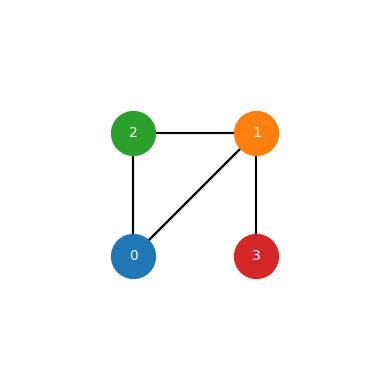

In [285]:
def plot_nsw(graph, edge_color='black', ax=None):
    if ax is None: _, ax = plt.subplots()

    for node in graph:
        # plot node
        x, y = node.embedding
        ax.scatter(x, y, s=1000, zorder=2)
        ax.text(x, y, node.idx, color='white', ha='center', va='center')
        # plot edges
        for neighbor in node.neighbors:
            x0, y0 = node.embedding
            x1, y1 = graph[neighbor].embedding
            ax.plot([x0, x1], [y0, y1], color=edge_color, zorder=1)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.set_aspect('equal')
    plt.axis('off')
    # plt.show()


graph = [
    Node(0, (1, 1), [1, 2]),
    Node(1, (2, 2), [0, 2]),
    Node(2, (1, 2), [0, 1]),
    Node(3, (2, 1), [1]),
]

plot_nsw(graph)